In [19]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from K_nearest import K_nearest

with open("reviewstrain.txt", "r") as file:
    X_train = []
    y_train = []
    for line in file:
        # exclude the label
        X_train.append(line[1:].strip())
        y_train.append(int(line[0]))

with open("reviewstest.txt", "r") as file:
    X_test = []
    y_test = []
    for line in file:
        X_test.append(line[1:].strip())
        y_test.append(int(line[0]))

corpus = X_train + X_test

In [20]:
vectorizer = CountVectorizer()
d_t_matrix= vectorizer.fit_transform(X_train)
voc_idx = d_t_matrix.sum(axis=0)
vocabulary = np.asarray(vectorizer.get_feature_names())

## Experienment and Check the first sentence

In [21]:
vocabulary[d_t_matrix[0].nonzero()[1]]

array(['films', 'horror', '1930s', 'beast', 'the', 'beauty', 'of',
       'imagining', 're', 'transporting', 'finally', 'and', 'funny',
       'stirring'], dtype='<U17')

In [22]:
temp = {'term': vectorizer.get_feature_names(), 'freq':np.asarray(voc_idx).squeeze()}
voc_df = pd.DataFrame(temp)
voc_df.head()

,term,freq
0,10,5
1,100,1
2,105,1
3,11,2
4,12,1


## The 5 most frequent words

In [23]:
voc_df.nlargest(5, 'freq')

,term,freq
5004,the,1262
225,and,923
3382,of,826
5082,to,529
2643,is,466


## The entropy of the whole sentence

In [24]:
y_train = np.asarray(y_train)

In [25]:
n_1 = y_train.sum()
n_t = y_train.shape[0]
n_0 = n_t -n_1
total_entropy = -((n_1/n_t)*np.log2(n_1/n_t) + (n_0/n_t)*np.log2(n_0/n_t))
print(total_entropy)

0.9952229310409331


In [26]:
d_t_matrix[0].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([1872, 2379,   11,  443, 5004,  448, 3382, 2453, 3935, 5143, 1875,
         225, 2031, 4747], dtype=int32))

In [27]:
d_t_ndarr = d_t_matrix.toarray()

## Calculate the infomation gain of every attributes

In [38]:
from collections import defaultdict

# When the token is equal to 1
num_total_dic = defaultdict(lambda:0)
num_1_dic = defaultdict(lambda:0)
num_0_dic = defaultdict(lambda:0)

for i, s in enumerate(d_t_ndarr):
    for idx in s.nonzero()[0]:
        num_total_dic[idx] += 1
        if y_train[i] == 1:
            num_1_dic[idx] += 1
        else:
            num_0_dic[idx] += 1

In [62]:
# When the token is equal to 0
_num_total_dic = defaultdict(lambda:0)
_num_1_dic = defaultdict(lambda:0)
_num_0_dic = defaultdict(lambda:0)
for i, s in enumerate(d_t_ndarr):
    for idx in np.where(s==0)[0]:
        _num_total_dic[idx] += 1
        if y_train[i] == 1:
            _num_1_dic[idx] += 1
        else:
            _num_0_dic[idx] += 1

In [98]:
# Add new columns
df1 = pd.DataFrame.from_dict(data= num_total_dic, orient='index', columns=['num_total'])
df2 = pd.DataFrame.from_dict(data= num_1_dic, orient='index', columns=['num_1'])
df3 = pd.DataFrame.from_dict(data= num_0_dic, orient='index', columns=['num_0'])
df4 = pd.DataFrame.from_dict(data= _num_total_dic, orient='index', columns=['_num_total'])
df5 = pd.DataFrame.from_dict(data= _num_1_dic, orient='index', columns=['_num_1'])
df6 = pd.DataFrame.from_dict(data= _num_0_dic, orient='index', columns=['_num_0'])
new_voc_df = voc_df.join(df1)
new_voc_df = new_voc_df.join(df2)
new_voc_df = new_voc_df.join(df3)
new_voc_df = new_voc_df.join(df4)
new_voc_df = new_voc_df.join(df5)
new_voc_df = new_voc_df.join(df6)
# Fill NaN with 0
new_voc_df = new_voc_df.fillna(0)
new_voc_df.head(5)

,term,freq,num_total,num_1,num_0,_num_total,_num_1,_num_0
0,10,5,5,2.0,3.0,1495,809,686
1,100,1,1,0.0,1.0,1499,811,688
2,105,1,1,0.0,1.0,1499,811,688
3,11,2,2,1.0,1.0,1498,810,688
4,12,1,1,1.0,0.0,1499,810,689


In [100]:
def get_information_gain(x):
    e1 = -(x.num_0/x.num_total*np.log2(x.num_0/x.num_total) 
             + x.num_1/x.num_total*np.log2(x.num_1/x.num_total))
    e2 = -(x._num_0/x._num_total*np.log2(x._num_0/x._num_total) 
             + x._num_1/x._num_total*np.log2(x._num_1/x._num_total))
    after = x.num_total/d_t_ndarr.shape[0] * e1+ x._num_total/d_t_ndarr.shape[0] * e2
    return total_entropy-after

new_voc_df=new_voc_df.assign(information_gain= lambda x: get_information_gain(x))
new_voc_df = new_voc_df.fillna(0)

/Users/LiZhuolun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/Users/LiZhuolun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


In [207]:
new_voc_df.nlargest(50,'information_gain')

,term,freq,num_total,num_1,num_0,_num_total,_num_1,_num_0,information_gain
399,bad,50,48,3.0,45.0,1452,808,644,0.025357
487,best,49,47,45.0,2.0,1453,766,687,0.020668
5098,too,42,35,5.0,30.0,1465,806,659,0.011856
3228,moving,26,26,25.0,1.0,1474,786,688,0.011615
225,and,923,739,444.0,295.0,761,367,394,0.010230
1613,entertaining,23,23,22.0,1.0,1477,789,688,0.009924
3143,minutes,23,22,2.0,20.0,1478,809,669,0.009830
5036,this,206,201,80.0,121.0,1299,731,568,0.009135
5577,with,198,183,126.0,57.0,1317,685,632,0.009075
1458,dull,20,20,2.0,18.0,1480,809,671,0.008500


## Train a neural network with the top 50 attributes

In [187]:
voca = new_voc_df.nlargest(50,'information_gain')['term']

In [188]:
new_X_train = 1.*(d_t_ndarr[:,voca.index]>0)

### Covert y_train

In [213]:
import neural_network 
import importlib
importlib.reload(neural_network)
new_y_train=neural_network.convert_y_to_vect(y_train)

In [214]:
import importlib
importlib.reload(neural_network)

nn_structure = [50,100,2]
W, b, avg_cost_func =neural_network.train_nn(nn_structure,new_X_train,new_y_train, 2000)

Starting gradient descent for 2000 iterations
Iteration 0 of 2000
Iteration 1000 of 2000


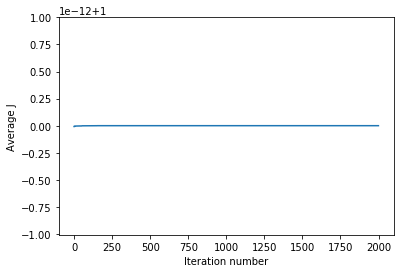

In [215]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [216]:
temp = vectorizer.transform(X_test)
new_X_test = 1.*(temp[:,voca.index]>0).toarray()

In [217]:
from sklearn.metrics import accuracy_score 
y_pred = neural_network.predict_y(W, b, new_X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 45.4%


## Using Zero-R

In [218]:
y_train.sum()/len(y_train)

0.5406666666666666

In [182]:
print('Prediction accuracy is {}%'.format(accuracy_score(y_test,[1]*len(y_test)) * 100))

Prediction accuracy is 54.6%
